# Detecting Sarcasm in Text
### Calvin Choi

The purpose of this project to the develop a model that can accurately discern sarcastic comments when provided the raw text. The process includes parsing the text, engineering informative features and applying text preprocessing before using classification algorithms to classify the text.

The data used in this study includes a pre-labelled dataset downloaded from Kaggle. As per the author, the dataset contains sarcastic and non-sarcastic comments, labelled as 1 and 0 respectively, that was scraped from Reddit. To accurately identify sarcasm in the comments, the author relied on the Reddit-specific tag /s which users typically utilize to designate sarcasm in their comment. The dataset includes 1,010,774 comments and attributes related to each comment, such as the number of likes, the date it was made, the parent comment, etc. In addition, the original dataset includes a perfect class balance between sarcastic and non-sarcastic comments.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
reddit = pd.read_csv('train-balanced-sarcasm.csv')

In [3]:
reddit.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## 1. EDA

Exploratory data analysis (EDA) will be conducted on the data to derive insight. The insight gained from this section will be used to drive feature engineering.  

In [4]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [5]:
reddit['label'].value_counts()

1    505413
0    505413
Name: label, dtype: int64

The above numbers indicate that there is a perfect ratio of sarcastic to non-sarcastic comments in this dataset. As this is extremely rare in a real-world scenerio, it should be noted that the data presented at this point is simply what the authors of the data had provided.

In [6]:
reddit.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

There are 53 instances with null values under the comment feature, which will be removed from the dataset.

In [7]:
# Remove all rows is NA 
reddit = reddit[reddit['comment'].notna()]

**Analyzing n-grams of Sarcastic Comments**

Here bigrams and trigrams are extracted from the comment feature to gain understanding into what the most common two and three word combinations are with respect to sarcastic comments. This analysis also determines the feasibility of introducing a bag of ngrams as the input for the classification model, rather than a collection of unigrams.

In [8]:
# First remove stop words in the comments
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [9]:
reddit['comment_without_stopwords'] = reddit['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [11]:
# Create function to find ngrams in 'comment' column 
def ngrams(comments, n):
    return list(zip(*[comments[i:] for i in range(n)]))

# Create dataframe with all bigrams and trigrams
df_ngrams = pd.DataFrame()
df_ngrams['bigrams'] = reddit[reddit['label']==1]['comment_without_stopwords'].map(lambda x: ngrams(x.split(" "), 2))
df_ngrams['trigrams'] = reddit[reddit['label']==1]['comment_without_stopwords'].map(lambda x: ngrams(x.split(" "), 3))
df_ngrams.head()

,bigrams,trigrams
33,"[(But, they'll), (they'll, reviews!)]","[(But, they'll, reviews!)]"
44,"[(wow, totally), (totally, unreasonable), (unr...","[(wow, totally, unreasonable), (totally, unrea..."
45,"[(Ho, ho), (ho, ho...), (ho..., But), (But, Me...","[(Ho, ho, ho...), (ho, ho..., But), (ho..., Bu..."
66,"[(I, can't), (can't, wait), (wait, @potus), (@...","[(I, can't, wait), (can't, wait, @potus), (wai..."
69,"[(gotta, love), (love, teachers), (teachers, g...","[(gotta, love, teachers), (love, teachers, giv..."


In [12]:
from collections import Counter
from itertools import chain

In [13]:
# Generate list of top 10 bigrams in the sarcastic class, and count number of comments that contain each bigram 
bigrams = df_ngrams['bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigrams = [(x.lower(), y.lower()) for x,y in bigrams]

top10_bigrams = Counter(bigrams).most_common(10)
top10_bigrams

[(("i'm", 'sure'), 5180),
 (('i', 'think'), 4991),
 (('i', 'thought'), 2936),
 (('you', 'forgot'), 2819),
 (('i', 'know'), 2449),
 (('i', 'guess'), 2281),
 (('sounds', 'like'), 1959),
 (('i', "can't"), 1804),
 (('i', 'see'), 1593),
 (('good', 'thing'), 1566)]

In [14]:
# Generate list of top 10 trigrams in the sarcastic class, and count number of comments that contain each trigram 
trigrams = df_ngrams['trigrams'].tolist()
trigrams = list(chain(*trigrams))
trigrams = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams]

top10_trigrams = Counter(trigrams).most_common(10)
top10_trigrams

[(('but', 'i', 'thought'), 534),
 (("i'm", 'pretty', 'sure'), 449),
 (('i', 'think', 'forgot'), 434),
 (('i', "can't", 'wait'), 423),
 (('you', 'dropped', 'this:'), 344),
 (('i', 'think', 'dropped'), 318),
 (('i', 'guess', 'i'), 317),
 (('yeah,', "i'm", 'sure'), 312),
 (('i', "can't", 'believe'), 310),
 (('you', 'sound', 'like'), 236)]

The most common bigram associated with sarcastic comments is "i'm sure" with 5,180 comments containing this bigram. The most common trigram is "but i thought" with 534 comments containing this bigram. Other bigrams and trigrams presented above are not uncommon with sarcastic phrases. 

**Comparing Comment Length in Sarcastic and Non-Sarcastic Comments**

Next, the length of each commennt will be analyzed to observe any difference between sarcastic and non-sarcastic comments.

In [15]:
# Create new feature that count the number of words in each comment 
reddit['comment length'] = reddit['comment'].str.split().str.len()

(0, 100)

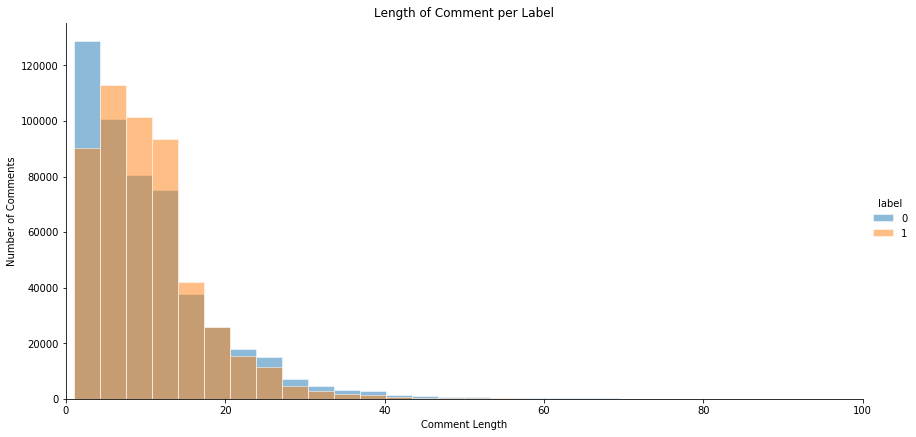

In [18]:
# Barplot showing distribution of number of comments at each comment length from 0 to 100 words 
g = sns.FacetGrid(reddit[reddit['comment length']<100], hue="label", height=6, aspect=2)
g = g.map(plt.hist, 'comment length', bins=30, alpha=0.5, ec='white').add_legend()
plt.title("Length of Comment per Label")
ylabel = plt.ylabel("Number of Comments")
xlabel = plt.xlabel("Comment Length")
plt.xlim(0,100)

The above bar plot present the distribution of the number of comments at each comment length, from 0 to 100 words, for sarcastic to non-sarcastic comments.

**Comparing the number of Ellipses in Sarcastic vs Non-sarcastic Comments**

Sarcasm in text may differentiate from non-sarcastic text in the number and types of punctuations used. First, the number of ellipses (...) in each comment will be calculated. Then the differences between sarcastic and non-sarcastic comments based on these counts will be analyzed for insight. 

In [19]:
# Create new feature that counts the number of ellipsis in each comment
reddit['# of ellipsis'] = reddit['comment'].apply(lambda x : x.count('...'))

In [21]:
# For comments that contain 1-4 ellipsis, count the number of sarcastic vs. non-sarcastic comments
num_sarcastic  = []
num_nonsarcastic = []
for i in range(1,5):
    num_sarcastic.append(len(reddit[(reddit['# of ellipsis']==i)&(reddit['label']==1)]))
    num_nonsarcastic.append(len(reddit[(reddit['# of ellipsis']==i)&(reddit['label']==0)]))

# Create df that contain above info and the proportion of sarcastic to non-sarcastic comments
ellipsis_table = pd.DataFrame()
ellipsis_table['# of Sarcastic Comments'] = num_sarcastic
ellipsis_table['# of Non-Sarcastic Comments'] = num_nonsarcastic
ellipsis_table['Proportion of Sarcastic Comment'] = ellipsis_table.iloc[:,0]/(ellipsis_table.iloc[:,0]+ellipsis_table.iloc[:,1])
ellipsis_table.index.names = ['# of Ellipsis in Comment']
ellipsis_table.index += 1
ellipsis_table

,# of Sarcastic Comments,# of Non-Sarcastic Comments,Proportion of Sarcastic Comment
# of Ellipsis in Comment,,,
1,32150,29951,0.5177
2,3732,3039,0.5512
3,648,524,0.5529
4,175,134,0.5663


The above table show that as the number of ellipsis in a comment increases, the porportion of sarcastic to non-sarcastic comments also increase. Below are pie charts illustrating the same point in a visual manner.

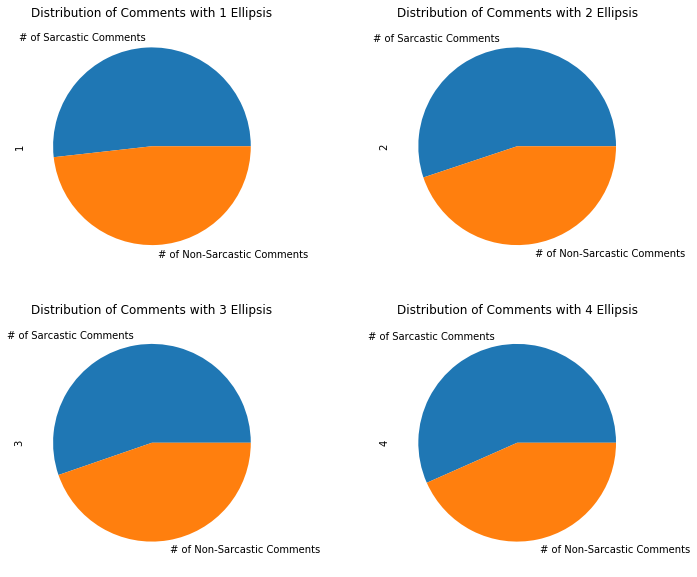

In [22]:
# Remove last column and transpose above table.
ellipsis_pie = ellipsis_table[ellipsis_table.columns[:-1]].transpose()

# Plot pie chart for each distribution of comments, from 1 to 4 ellipsis.
cols = range(1,5)
fig, ax = plt.subplots(2,2, figsize=(12, 10))
for i, axis in enumerate(ax.flatten()):    
    ellipsis_pie.plot(kind='pie', y=cols[i], legend=False, title='Distribution of Comments with %s Ellipsis' %(cols[i]), ax=axis)

**Counting Consecutive Characters**

In this section, the number of repeating consecutive characters in a word within a comment will be analyzed for any difference in sarcasm and non-sarcasm. For example, consider the following comment from the dataset:

*"Oooo you're so edgy putting that here."*

Here, the count of repeating consectutive characters is 4. If a comment contains two words with repeating consecutive characters, only the word with the highest number will be observed. 

In [25]:
# Define function to count the number of characters that repeat the most. 
import re

def consecutive_repeating_chars(x):
    repeating_chars = [match[0] for match in re.findall(r'((\w)\2{2,})', x)]
    if not repeating_chars:
        return 0
    else:
        repeating_chars = " ".join(repeating_chars)
        max_repeated = max([len(word) for word in repeating_chars.split()])
        return(max_repeated)

In [26]:
# Apply function to comments and create new feature with the counts
reddit['num_repeated_chars'] = reddit['comment'].apply(lambda x : consecutive_repeating_chars(x))

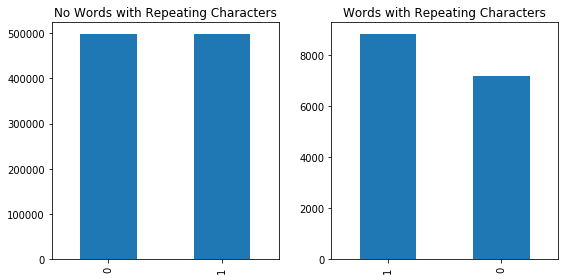

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2)
reddit[reddit['num_repeated_chars']==0]['label'].value_counts().plot(kind='bar', figsize=(8,4), ax=axes[0], title='No Words with Repeating Characters')
reddit[reddit['num_repeated_chars']>=1]['label'].value_counts().plot(kind='bar', figsize=(8,4), ax=axes[1], title='Words with Repeating Characters')
plt.tight_layout()

The left barplot presents the distribution of sarcastic and non-sarcastic comments containing words with no repeating characters, while the plot on the right show the distribution for comments containing at least one word with repeating characters. It can be observed that less than 2% of comments in the dataset contain repeating characters, while the vast majority of comments do not.

In [28]:
# For comments that contain 1-4 ellipsis, count the number of sarcastic vs. non-sarcastic comments
num_sarcastic  = []
num_nonsarcastic = []
for i in range (3,11):
    num_sarcastic.append(len(reddit[(reddit['num_repeated_chars']==i)&(reddit['label']==1)]))
    num_nonsarcastic.append(len(reddit[(reddit['num_repeated_chars']==i)&(reddit['label']==0)]))

# Create df that contain above info and the proportion of sarcastic to non-sarcastic comments
rep_table = pd.DataFrame()
rep_table['# of Sarcastic Comments'] = num_sarcastic
rep_table['# of Non-Sarcastic Comments'] = num_nonsarcastic
rep_table['Proportion of Sarcastic Comment'] = rep_table.iloc[:,0]/(rep_table.iloc[:,0]+rep_table.iloc[:,1])
rep_table.index.names = ['# of repeated characters']
rep_table.index += 3
rep_table

,# of Sarcastic Comments,# of Non-Sarcastic Comments,Proportion of Sarcastic Comment
# of repeated characters,,,
3,4407,3406,0.5641
4,1753,1221,0.5894
5,982,794,0.5529
6,558,454,0.5514
7,323,298,0.5201
8,198,205,0.4913
9,133,126,0.5135
10,85,97,0.4670


The above table shows the proportion of sarcastic to non-sarcastic comments as the number of repeating characters increase from 1 to 10. Sarcastic comments appear to have the largest proportion of comments at four repeating characters, with 59% of those comments being sarcastic. As the number increases, so does the proportion of sarcastic comments.

## 2. Classification

In this section, classification algorithms will be used to train on the input features to attempt to classify each comment to one of the target classes.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

Define X and y, and split data into training and testing set

In [30]:
y = reddit['label']
X = reddit['comment']

In [31]:
# Transform comments into feature vector and assign tfidf weights to each feature
tfidfvec = TfidfVectorizer()
X = tfidfvec.fit_transform(X)

In [34]:
# Split the data into train and test sets based on a 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

**Multinomial Naive Bayes**

In [35]:
nb_multi = MultinomialNB()

In [36]:
nb_multi.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
predictions_nb_multi = nb_multi.predict(X_test)

              precision    recall  f1-score   support

           0       0.67      0.66      0.67    151844
           1       0.67      0.68      0.67    151388

    accuracy                           0.67    303232
   macro avg       0.67      0.67      0.67    303232
weighted avg       0.67      0.67      0.67    303232





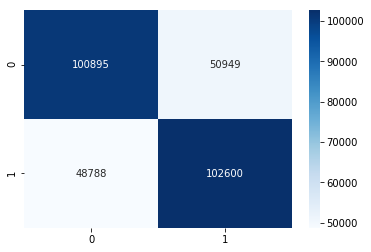

In [38]:
print(classification_report(y_test, predictions_nb_multi))
print('\n')
sns.heatmap(confusion_matrix(y_test, predictions_nb_multi), annot=True, cmap='Blues', fmt='g');

Regarding the class of interest, which is the sarcastic class, the Naive Bayes model was correct in its predictions 67% of the time, and was able to catch 68% of the actual sarcastic comments. 

To look at actual counts, the confusion matrix indicate that the NB model predicted 102,600 of the 151,388 actual sarcastic comments. It made 153,549 predictions that a comment would be sarcastic and was correct 102,600 times.

**Linear Support Vector Machines**

In [86]:
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=3000)
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [87]:
predictions_svc = svc.predict(X_test)

              precision    recall  f1-score   support

           0       0.67      0.71      0.69    151589
           1       0.69      0.65      0.67    151643

    accuracy                           0.68    303232
   macro avg       0.68      0.68      0.68    303232
weighted avg       0.68      0.68      0.68    303232





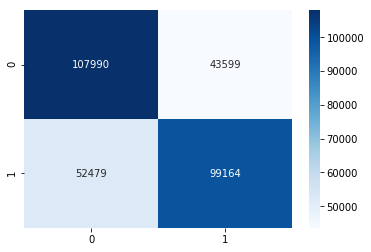

In [88]:
print(classification_report(y_test, predictions_svc))
print('\n')
sns.heatmap(confusion_matrix(y_test, predictions_svc), annot=True, cmap='Blues', fmt='g');